In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score, balanced_accuracy_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
from collections import Counter

sns.set_style('darkgrid')
sns.set_palette('Greens_d')

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
dataset = datasets.ImageFolder(root='./data/color')
labels = np.array(dataset.targets)
indices = np.arange(len(dataset))
# Number of images per class
plant_disease_counts = Counter([dataset.classes[label] for label in labels]).most_common()
# Class weights are used to balance the loss function
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)

In [3]:
for label, count in plant_disease_counts:
    print(f'{label}: {count / len(labels) * 100:.2f}%')

Orange___Haunglongbing_(Citrus_greening): 10.14%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 9.86%
Soybean___healthy: 9.37%
Peach___Bacterial_spot: 4.23%
Tomato___Bacterial_spot: 3.92%
Tomato___Late_blight: 3.52%
Squash___Powdery_mildew: 3.38%
Tomato___Septoria_leaf_spot: 3.26%
Tomato___Spider_mites Two-spotted_spider_mite: 3.09%
Apple___healthy: 3.03%
Tomato___healthy: 2.93%
Blueberry___healthy: 2.77%
Pepper,_bell___healthy: 2.72%
Tomato___Target_Spot: 2.59%
Grape___Esca_(Black_Measles): 2.55%
Corn_(maize)___Common_rust_: 2.20%
Grape___Black_rot: 2.17%
Corn_(maize)___healthy: 2.14%
Strawberry___Leaf_scorch: 2.04%
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1.98%
Cherry_(including_sour)___Powdery_mildew: 1.94%
Potato___Early_blight: 1.84%
Potato___Late_blight: 1.84%
Tomato___Early_blight: 1.84%
Pepper,_bell___Bacterial_spot: 1.84%
Corn_(maize)___Northern_Leaf_Blight: 1.81%
Tomato___Leaf_Mold: 1.75%
Cherry_(including_sour)___healthy: 1.57%
Apple___Apple_scab: 1.16%
Apple___Black_rot: 1.14%


<Axes: >

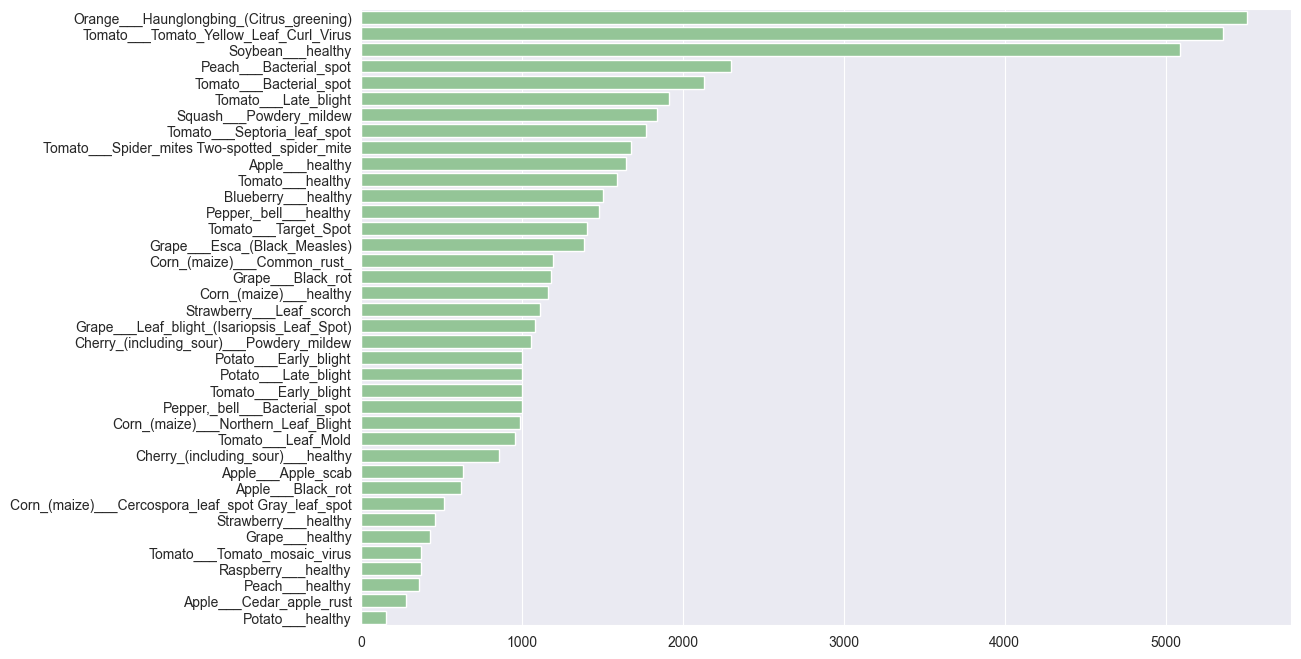

In [4]:
plt.figure(figsize=(12,8))
sns.barplot(x=[x[1] for x in plant_disease_counts], y=[x[0] for x in plant_disease_counts])

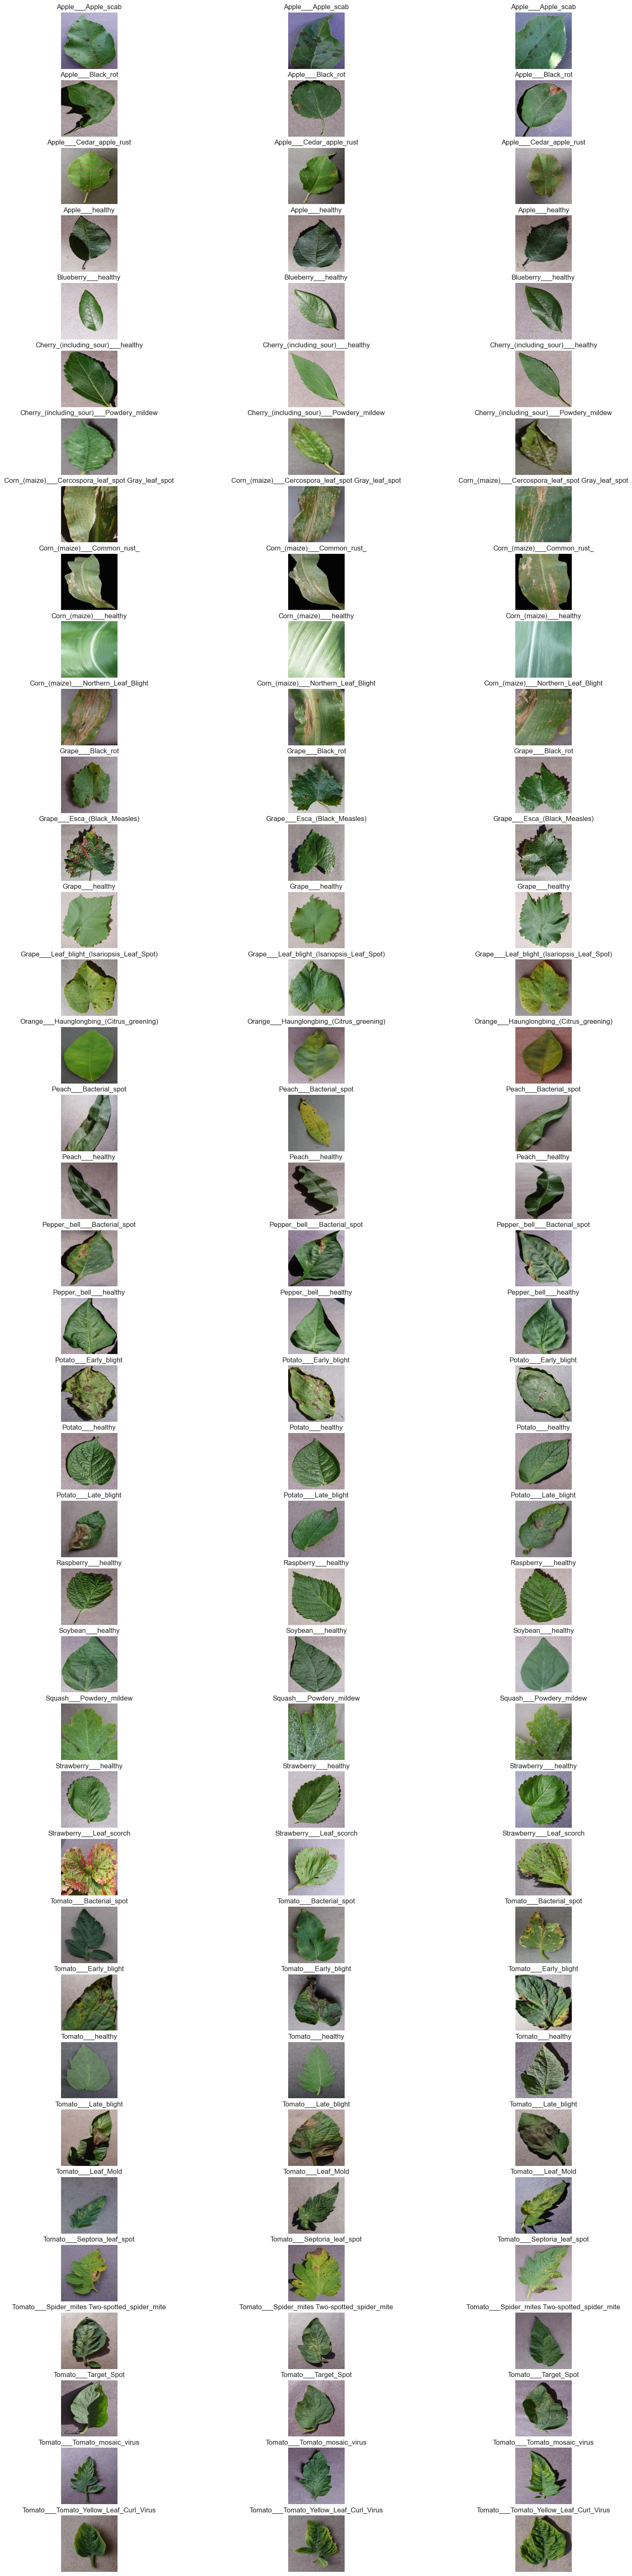

In [5]:
fig, axes = plt.subplots(38, 3, figsize=(20, 80))
for i, disease_class in enumerate(os.listdir('./PlantVillage-Dataset/raw/color')):
    class_images = [img for img in os.listdir(f'./PlantVillage-Dataset/raw/color/{disease_class}')][:3]
    for j, image in enumerate(class_images):
        ax = axes[i, j]
        img = Image.open(f'./PlantVillage-Dataset/raw/color/{disease_class}/{image}')
        ax.imshow(img)
        ax.set_title(disease_class)
        ax.axis('off')    

In [6]:
def training_transforms(image_size=224):
    return A.Compose(
        [
            # Step 1: Resize to image_size
            A.ToRGB(),
            A.Resize(image_size, image_size),
            
            # Step 2: Random geometric augmentations
            A.OneOf(
                [
                    A.HorizontalFlip(p=1.0),
                    A.VerticalFlip(p=1.0),
                    A.RandomRotate90(p=1.0),
                    A.Transpose(p=1.0),
                ],
                p=0.5,
            ),
            
            # Step 3: Random color augmentations
            A.OneOf(
                [
                    A.RandomBrightnessContrast(
                        brightness_limit=0.2, contrast_limit=0.2, p=1.0
                    ),
                    A.HueSaturationValue(
                        hue_shift_limit=20,
                        sat_shift_limit=30,
                        val_shift_limit=20,
                        p=1.0,
                    ),
                ],
                p=0.5,
            ),
            
            # Step 4: Random noise
            A.OneOf(
                [
                    A.GaussianBlur(blur_limit=3, p=1.0),
                    A.MotionBlur(blur_limit=3, p=1.0),
                    A.MedianBlur(blur_limit=3, p=1.0),
                ],
                p=0.5,
            ),
            
            # Step 5: Normalize
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ]
    )


def validation_transforms(image_size=224):
    return A.Compose(
        [
            A.Resize(image_size, image_size),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ]
    )
    
def transform_helper(img_path):
    img = Image.open(img_path)
    return img


class Transform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, image):
        image = np.array(image.convert("RGB"))
        return self.transform(image=image)["image"]

In [7]:
# This ensures that the train, val, and test splits contain the same proportion of images from each class
# Note that this only generates indices, not the actual datasets. The datasets are created in the next cell
train_idx, val_test_idx, y_train, y_val_test = train_test_split(
    indices, labels, test_size=0.3, random_state=42, stratify=labels
)
val_idx, test_idx, y_val, y_test = train_test_split(
    val_test_idx, y_val_test, test_size=0.5, random_state=42, stratify=y_val_test
)

In [ ]:
train_dataset = datasets.ImageFolder(
    root="./PlantVillage-Dataset/raw/color",
    transform=Transform(training_transforms()),
    loader=transform_helper,
)
val_dataset = datasets.ImageFolder(
    root="./PlantVillage-Dataset/raw/color",
    transform=Transform(validation_transforms()),
    loader=transform_helper,
)

train_subset = torch.utils.data.Subset(train_dataset, train_idx)
val_subset = torch.utils.data.Subset(val_dataset, val_idx)
test_subset = torch.utils.data.Subset(val_dataset, test_idx)

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

In [9]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor
    
unorm = UnNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

c:\Users\marcu\Documents\Coding\PythonProjects\.venv\Lib\site-packages\albumentations\core\transforms_interface.py:313: UserWarning: The image is already an RGB.
  target_function(ensure_contiguous_output(arg), **params),


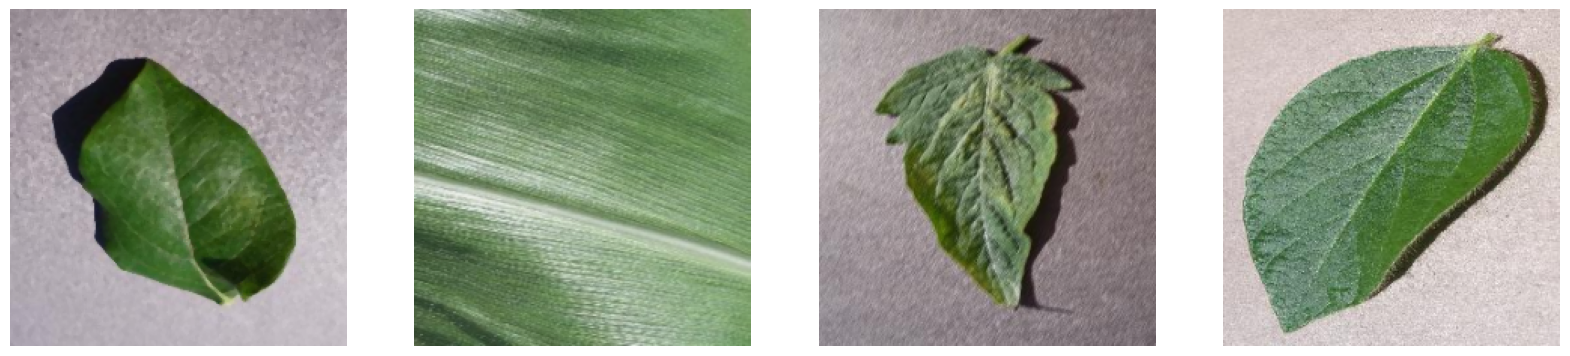

In [10]:
first_batch = next(iter(train_loader))
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    ax[i].imshow(unorm(first_batch[0][i]).permute(1, 2, 0))
    ax[i].axis('off')

In [11]:
class CA(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.mlp = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, 1, bias=False),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = self.mlp(self.avg_pool(x))
        max_ = self.mlp(self.max_pool(x))
        return x * self.sigmoid(avg + max_)


class SA(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        max_, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg, max_], dim=1)
        return x * self.sigmoid(self.conv(x_cat))


class CBAM(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.ca = CA(channels)
        self.sa = SA()

    def forward(self, x):
        x = self.ca(x)
        x = self.sa(x)
        return x


class ResNetBlockCBAM(nn.Module):
    def __init__(self, in_channels, out_channels, use_cbam, stride=2):
        super().__init__()

        self.use_cbam = use_cbam

        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.cbam = CBAM(out_channels) if use_cbam else nn.Identity()

        self.shortcut = nn.Identity()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.cbam(out)
        out += self.shortcut(x)
        return F.relu(out)


class PlantDiseaseMulticlassResNetOptionalCBAM(nn.Module):
    def __init__(self, num_classes, use_cbam):
        super(PlantDiseaseMulticlassResNetOptionalCBAM, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )

        self.layer1 = ResNetBlockCBAM(32, 64, stride=1, use_cbam=False)
        self.layer2 = ResNetBlockCBAM(64, 128, use_cbam=use_cbam)
        self.layer3 = ResNetBlockCBAM(128, 256, use_cbam=use_cbam)

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Linear(256, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.gap(x)
        x = torch.flatten(x, 1)

        x = self.classifier(x)

        return x

In [12]:
def train_model(model, model_name, config, train_loader, val_loader, class_weights_tensor):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    optimizer = torch.optim.Adam(
    model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"]
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=config["patience"], factor=0.3
    )
    criterion = nn.CrossEntropyLoss(
        weight=class_weights_tensor
    )

    print(f"Training {model_name}...")
    for epoch in range(config["num_epochs"]):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        print(f"Epoch {epoch + 1}/{config['num_epochs']}, Train Loss: {train_loss:.4f}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        scheduler.step(val_loss)
        print(f"Epoch {epoch + 1}/{config['num_epochs']}, Val Loss: {val_loss:.4f}\n")
        
        current_lr = optimizer.param_groups[0]["lr"]
        print(f"LR: {current_lr:.2e}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"{model_name}_best.pth")
            print(f"New best model saved to {model_name}_best.pth\n")

    print(f"\nTraining for {model_name} complete.")
    
    return train_losses, val_losses

In [13]:
resnet_no_cbam = PlantDiseaseMulticlassResNetOptionalCBAM(38, False)
resnet_with_cbam = PlantDiseaseMulticlassResNetOptionalCBAM(38, True)

config = {
    "learning_rate": 3e-4,
    "num_epochs": 10,
    "weight_decay": 1e-4,
    "patience": 3
}

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32, device=device)

In [14]:
set_seed(42)
resnet_no_cbam.to(device)
train_losses_no_cbam, val_losses_no_cbam = train_model(resnet_no_cbam, "resnet_no_cbam", config, train_loader, val_loader, class_weights_tensor)

resnet_with_cbam.to(device)
train_losses_with_cbam, val_losses_with_cbam = train_model(resnet_with_cbam, "resnet_with_cbam", config, train_loader, val_loader, class_weights_tensor)

Training resnet_no_cbam...
Epoch 1/10, Train Loss: 2.2639
Epoch 1/10, Val Loss: 1.2644

LR: 3.00e-04
New best model saved to resnet_no_cbam_best.pth

Epoch 2/10, Train Loss: 1.6064
Epoch 2/10, Val Loss: 0.9962

LR: 3.00e-04
New best model saved to resnet_no_cbam_best.pth

Epoch 3/10, Train Loss: 1.3640
Epoch 3/10, Val Loss: 0.7892

LR: 3.00e-04
New best model saved to resnet_no_cbam_best.pth

Epoch 4/10, Train Loss: 1.1853
Epoch 4/10, Val Loss: 0.6411

LR: 3.00e-04
New best model saved to resnet_no_cbam_best.pth

Epoch 5/10, Train Loss: 1.0449
Epoch 5/10, Val Loss: 0.5703

LR: 3.00e-04
New best model saved to resnet_no_cbam_best.pth

Epoch 6/10, Train Loss: 0.9207
Epoch 6/10, Val Loss: 0.4509

LR: 3.00e-04
New best model saved to resnet_no_cbam_best.pth

Epoch 7/10, Train Loss: 0.8292
Epoch 7/10, Val Loss: 0.5135

LR: 3.00e-04
Epoch 8/10, Train Loss: 0.7337
Epoch 8/10, Val Loss: 0.3342

LR: 3.00e-04
New best model saved to resnet_no_cbam_best.pth

Epoch 9/10, Train Loss: 0.6747
Epoch 9

In [15]:
def plot_loss(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

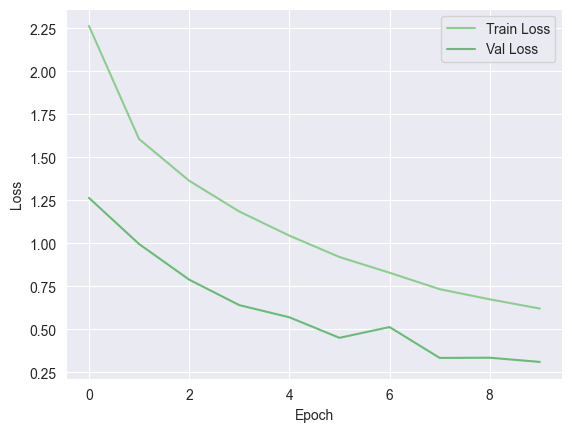

In [16]:
plot_loss(train_losses_no_cbam, val_losses_no_cbam)

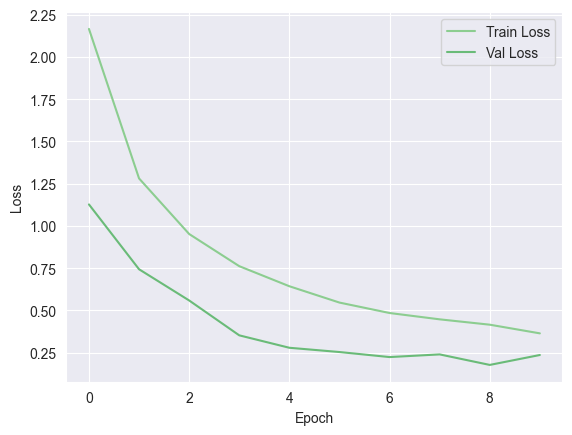

In [17]:
plot_loss(train_losses_with_cbam, val_losses_with_cbam)

In [58]:
from sklearn.metrics import f1_score, balanced_accuracy_score

def evaluate_model(model, test_loader, dataset):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    all_labels_class_labels = [dataset.classes[i] for i in all_labels]

    return {
        "y_pred": all_preds,
        "y_true": all_labels,
        "y_true_class_labels": all_labels_class_labels,
        "f1_unaveraged": f1_score(all_labels, all_preds, average=None),
        "macro_f1": f1_score(all_labels, all_preds, average="macro"),
        "weighted_f1": f1_score(all_labels, all_preds, average="weighted"),
        "micro_f1": f1_score(all_labels, all_preds, average="micro"),
        "balanced_accuracy": balanced_accuracy_score(all_labels, all_preds),
        "confusion_matrix": confusion_matrix(all_labels, all_preds, normalize="true"),
        "classification_report": classification_report(all_labels, all_preds, target_names=dataset.classes)
    }


In [59]:
resnet_no_cbam_test = PlantDiseaseMulticlassResNetOptionalCBAM(38, False).to(device)
resnet_no_cbam_test.load_state_dict(
    torch.load("resnet_no_cbam_best.pth", map_location=device)
)

resnet_cbam_test = PlantDiseaseMulticlassResNetOptionalCBAM(38, True).to(device)
resnet_cbam_test.load_state_dict(
    torch.load("resnet_with_cbam_best.pth", map_location=device)
)

resnet_no_cbam_test.eval()
resnet_cbam_test.eval()

PlantDiseaseMulticlassResNetOptionalCBAM(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): ResNetBlockCBAM(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (cbam): Identity()
    (shortcut): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): ResNetBlockCBAM(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  

In [60]:
resnet_no_cbam_results = evaluate_model(resnet_no_cbam_test, test_loader, dataset)
resnet_cbam_results = evaluate_model(resnet_cbam_test, test_loader, dataset)

In [61]:
for model_name, results in zip(["resnet_no_cbam", "resnet_with_cbam"], [resnet_no_cbam_results, resnet_cbam_results]):
    print(f"Classification Report for {model_name}:")
    print(results["classification_report"])
    print("\n")

Classification Report for resnet_no_cbam:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.86      0.80      0.83        94
                                 Apple___Black_rot       0.84      0.94      0.88        93
                          Apple___Cedar_apple_rust       0.95      1.00      0.98        41
                                   Apple___healthy       0.91      0.93      0.92       246
                               Blueberry___healthy       0.94      0.97      0.95       226
          Cherry_(including_sour)___Powdery_mildew       0.94      0.96      0.95       158
                 Cherry_(including_sour)___healthy       0.78      0.99      0.87       128
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.79      0.88      0.83        77
                       Corn_(maize)___Common_rust_       1.00      0.97      0.99       179
               Corn_(maize)___Norther

In [71]:
# F1-difference

f1_diff = resnet_cbam_results["f1_unaveraged"] - resnet_no_cbam_results["f1_unaveraged"]

plt.figure(figsize=(14, 5))
plt.bar(dataset.classes, f1_diff)
plt.axhline(0, linestyle="--")
plt.xlabel("Class labels")
plt.xticks(rotation=90)
plt.ylabel("F1 difference (CBAM minus no CBAM)")
plt.title("Per-class F1 improvement with CBAM")
plt.show()